# Task 8.5. Game of life
---
***Author: Piotr Skalski***

## 1. Imports

In [1]:
import numpy as np
import scipy.io as sio
import cv2
import os
import pprint
from tqdm import tqdm
import re

import display_util

import matplotlib.pyplot as plt
%matplotlib inline

## 2. Primary settings

In [2]:
SOURCE_DIR = "./../data/"
OUTPUT_DIR = "./../game_sim/"
DATA = "gra.mat"
NEIGHBORHOOD_SIZE = (3, 3)

## 3. Loading data

In [3]:
# building path to data
data_path = os.path.join(SOURCE_DIR, DATA)
# loading data
data = sio.loadmat(data_path)

### 3.1. Data overview

In [4]:
# Key list of data dictionary
pprint.pprint(list(data.keys()))

['gra2',
 'obraz',
 '__version__',
 'g',
 'gra',
 '__header__',
 'obrazSKEL',
 'lut',
 'plansza1',
 'plansza2',
 'i',
 '__globals__']


### 3.2. Filtering data

In [5]:
# Filtering data via regex
key_form = p = re.compile('^__.+__$')
# Definition of lists storing image data and their names
images = []
image_names = []

for key, value in data.items():
    if(key_form.match(key) is None):
        print("Image name: {}, image size: {}".format(key, value.shape))
        image_names.append(key)
        images.append(value)

Image name: gra2, image size: (13, 16)
Image name: obraz, image size: (61, 57)
Image name: g, image size: (61, 57)
Image name: gra, image size: (10, 10)
Image name: obrazSKEL, image size: (200, 200, 3)
Image name: lut, image size: (512, 1)
Image name: plansza1, image size: (10, 10)
Image name: plansza2, image size: (13, 16)
Image name: i, image size: (1, 1)


### 3.3. Display images

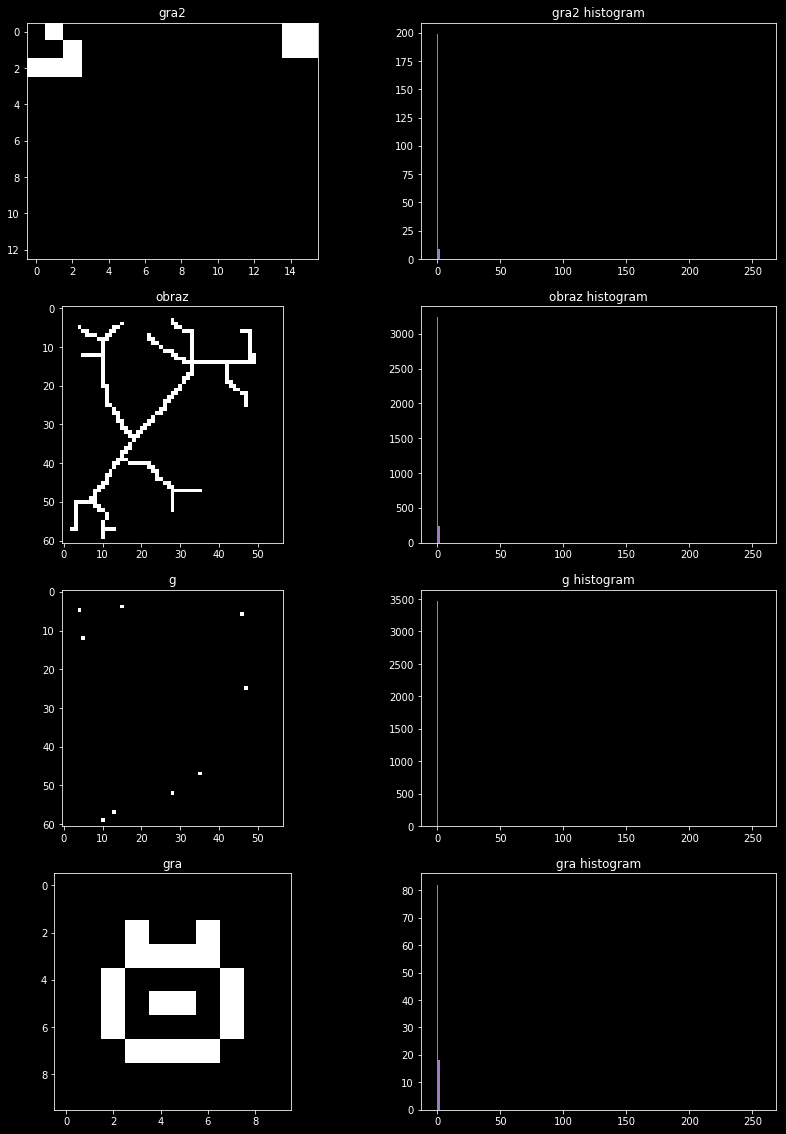

In [29]:
display_util.images_with_histograms(files_list=images[:4], names_list=image_names[:4])

## 4. Matlab to python colfilt polyfill (support function)

In [9]:
def rolling_window(a, shape):
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

In [26]:
def python_colfilt(data, window_shape, func, args):
    # acquisition of window size and image dimensions
    (window_height, window_width) = window_shape
    (data_rows, data_columns) = data.shape
    
    # preparation of memory for the returned array
    output = np.zeros(data.shape)
    
    # calculation of padding size
    vertical_padding = window_height // 2
    horizontal_padding = window_width // 2
    
    # addition of padding
    data_with_padding = np.pad(data, [(vertical_padding, vertical_padding), (horizontal_padding, horizontal_padding)], 
                               mode='constant', constant_values=0)
    
    # strides
    strides = rolling_window(data_with_padding, window_shape)
    
    for raw_inx in range(data_rows):
        for column_idx in range(data_columns):
            output[raw_inx, column_idx] = func(strides[raw_inx, column_idx], *args)
            
    return output

## 5. Definition of rules

In [11]:
def apply_rules(neighborhood):
    is_alive = neighborhood[1][1] == 1
    neighbors_number = neighborhood.sum() - neighborhood[1][1]
    
    if(is_alive and neighbors_number in (2, 3)):
        return 1
    elif(not is_alive and neighbors_number == 3):
        return 1
    else:
        return 0

In [12]:
def next_game_frame(board):
    return python_colfilt(board, (3, 3), apply_rules, [])

In [13]:
def game_of_life_simulation(start_board, iterations):
    game_boards = [start_board]
    for i in range(iterations):
        game_boards.append(next_game_frame(game_boards[-1]))
    return game_boards

In [16]:
def game_board_plot(image, title, file_name, size):
    plt.style.use('dark_background')
    fig = plt.figure(figsize=size)
    fig.suptitle(title, fontsize = 25)
    plt.imshow(image, 'gray')
    plt.savefig(file_name)
    plt.close()

In [27]:
board_name = "obraz"
board_image = data[board_name]
simulation = game_of_life_simulation(board_image, 100)
for index, simulation_frame in enumerate(simulation):
    frame_output_path = "./{}/{}_{:05}.png".format(OUTPUT_DIR, board_name, index)
    game_board_plot(simulation_frame, "", frame_output_path, (12,12))

## 6. Results of the simulation

<img src="./sim_plansza1.gif" alt="plansza1">

<img src="./sim_plansza2.gif" alt="plansza2">

<img src="./sim_obraz.gif" alt="obraz">